In [1]:
# imports
import time
import math
import json
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display as i_display

# plotting options
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rcParams['figure.figsize']=(23,15)


# constants
months = {'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}

## <u><i>PREPROCESSING</i></u>

In [2]:
# get processed df
def get_df():
    df = pd.read_csv(r'G:\HashCode_23\PLID_Bookings_Problem1.csv')
    df.head()
    
    parts = df["Booking_Date"].str.split("-", n = 3, expand = True)
    df.head()
    arr = df.to_numpy()

    # separate date of order

    # old method
    # df["year"]= parts[2].astype('int')
    # df["month"]= parts[1].astype('int')

    # new method
    df["month"] = df["Fiscal Month"].str[0:3].astype(str).map(months).astype(int)
    df["year"] = df["Fiscal Month"].str[6:].astype(int)

    df["Fiscal Month"] = df["Fiscal Month"].apply(lambda x: f'{months[x[0:3]]}-{int("20"+x[-2]+x[-1])}')
    df["Fiscal Month"] = pd.to_datetime(df["Fiscal Month"], format="%m-%Y")
    df["fiscal_date"] = df["Fiscal Month"]
    df["quarter"] = df['Fiscal Month'].dt.quarter

    # df["booking_date"] = df["Booking_Date"].astype(str)
    df["booking_date"] = pd.to_datetime(df["Booking_Date"], format="%d-%m-%Y")

    df['prod_info'] = df['Business Unit'] + df['Product Family'] + df['PLID']

    df["booked_qty"] = df["Booked_Qty"]

    # replace features with numbers
    df['business_unit'], business_unit_u = pd.factorize(df['Business Unit'])
    df['product_family'], product_family_u = pd.factorize(df['Product Family'])
    df['plid'] = df['PLID']
    # df['plid'], plid_u = pd.factorize(df['PLID'])

    # add features
    # -------------------------------------------------------------------------------------
    # feature 1 [mean change across last]
    df["mean_across_quarter"] = df.groupby(['plid', 'quarter', 'year'], as_index=False).agg({'booked_qty': 'mean'})['booked_qty']

    # feature 2 [percentage change in feature 1]
    df['percentage_mean_change'] = df.groupby(['plid', 'quarter', 'year'])['mean_across_quarter'].pct_change()

    # fill Na's
    df["mean_across_quarter"] = df["mean_across_quarter"].fillna(0)
    df["percentage_mean_change"] = df["percentage_mean_change"].fillna(0)

    feature_df = df[["mean_across_quarter","percentage_mean_change"]]
    feature_array = feature_df.to_numpy(dtype = 'float64')
    inf_array = np.isinf(feature_array)
    feature_array = np.where(inf_array, 0, feature_array)
    feature_df = pd.DataFrame(feature_array, columns = ["mean_across_quarter","percentage_mean_change"])
    # -------------------------------------------------------------------------------------
    df["mean_across_quarter"] = feature_df["mean_across_quarter"]
    df["percentage_mean_change"] = feature_df["percentage_mean_change"]
    # -------------------------------------------------------------------------------------

    df['plid'], plid_u = pd.factorize(df['PLID'])

    # print results
    print("Unique values per feature:")
    print("  Business Units:", df['business_unit'].nunique())
    print("  Product Families:", df['product_family'].nunique())
    print("  PLIDs:", df['plid'].nunique())
    print("  Years:", df['year'].nunique())
    print("  Months:", df['month'].nunique())
    print(list(df['year'].unique()))

    # store numerifications into json
    f = open("numerifications.json", 'w')
    d = {"Business Unit": {}, "Product Family": {}, "PLID": {}}

    for i, x in enumerate(business_unit_u):
        d["Business Unit"][i] = x

    for i, x in enumerate(product_family_u):
        d["Product Family"][i] = x

    for i, x in enumerate(plid_u):
        d["PLID"][i] = x

    json.dump(d, f, indent = 4)
    f.close()

    # remove old features
    df.drop('Fiscal Quarter', inplace=True, axis=1)
    df.drop('Business Unit', inplace=True, axis=1)
    df.drop('PLID', inplace=True, axis=1)
    df.drop('Fiscal Month', inplace=True, axis=1)
    df.drop('prod_info', inplace=True, axis=1)
    df.drop('Product Family', inplace=True, axis=1)
    df.drop('Booking_Date', inplace=True, axis=1)
    df.drop('Booked_Qty', inplace=True, axis=1)

    data = df.copy()
    df.head()
    
    return data

In [3]:
# load the data frame
df = get_df()
df.head()

Unique values per feature:
  Business Units: 18
  Product Families: 73
  PLIDs: 250
  Years: 9
  Months: 12
[2022, 2002, 2008, 2007, 2011, 2012, 2015, 2014, 2013]


,month,year,fiscal_date,quarter,booking_date,booked_qty,business_unit,product_family,plid,mean_across_quarter,percentage_mean_change
0,8,2022,2022-08-01,3,2016-08-01,204,0,0,0,8.666667,0.000000
1,10,2022,2022-10-01,4,2016-10-01,564,0,0,0,505.000000,0.000000
2,9,2022,2022-09-01,3,2016-09-01,1476,0,0,0,12.333333,0.423077
3,8,2002,2002-08-01,3,2017-08-01,374,0,0,0,73.500000,0.000000
4,10,2002,2002-10-01,4,2017-10-01,6094,0,0,0,193.500000,0.000000


## <u><i>TRAINING [RANDOM FOREST REGRESSOR]</i></u>

In [4]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
# Split the data into training and test sets
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
features = ['plid','month','year']

In [6]:
rf_model.fit(train_data[features], train_data['booked_qty'])

RandomForestRegressor(n_estimators=1000, random_state=42)

In [7]:

# Evaluate the performance of the model on the test data
test_predictions = rf_model.predict(test_data[features])
print(test_data[features],test_predictions)
mae = mean_absolute_error(test_data['booked_qty'], test_predictions)
rmse = mean_squared_error(test_data['booked_qty'], test_predictions, squared=False)
print('MAE: {:.2f}'.format(mae))
print('RMSE: {:.2f}'.format(rmse))

       plid  month  year
107       1      1  2011
5481    142      1  2007
2848     90      3  2008
8760    206      6  2011
8117    191      3  2007
...     ...    ...   ...
6618    162     11  2022
10545   238      4  2011
5914    151      7  2008
6582    160      2  2012
10703   240     11  2022

[2200 rows x 3 columns] [  143.906        870.066        951.401      ... 18058.204
    60.232      24239.76753333]
MAE: 2827.94
RMSE: 8905.64


## <u><i>TRAINING [LSTM]</i></u>

In [8]:
df.reset_index()
df.head()

,month,year,fiscal_date,quarter,booking_date,booked_qty,business_unit,product_family,plid,mean_across_quarter,percentage_mean_change
0,8,2022,2022-08-01,3,2016-08-01,204,0,0,0,8.666667,0.000000
1,10,2022,2022-10-01,4,2016-10-01,564,0,0,0,505.000000,0.000000
2,9,2022,2022-09-01,3,2016-09-01,1476,0,0,0,12.333333,0.423077
3,8,2002,2002-08-01,3,2017-08-01,374,0,0,0,73.500000,0.000000
4,10,2002,2002-10-01,4,2017-10-01,6094,0,0,0,193.500000,0.000000


<Axes: xlabel='booking_date', ylabel='booked_qty'>

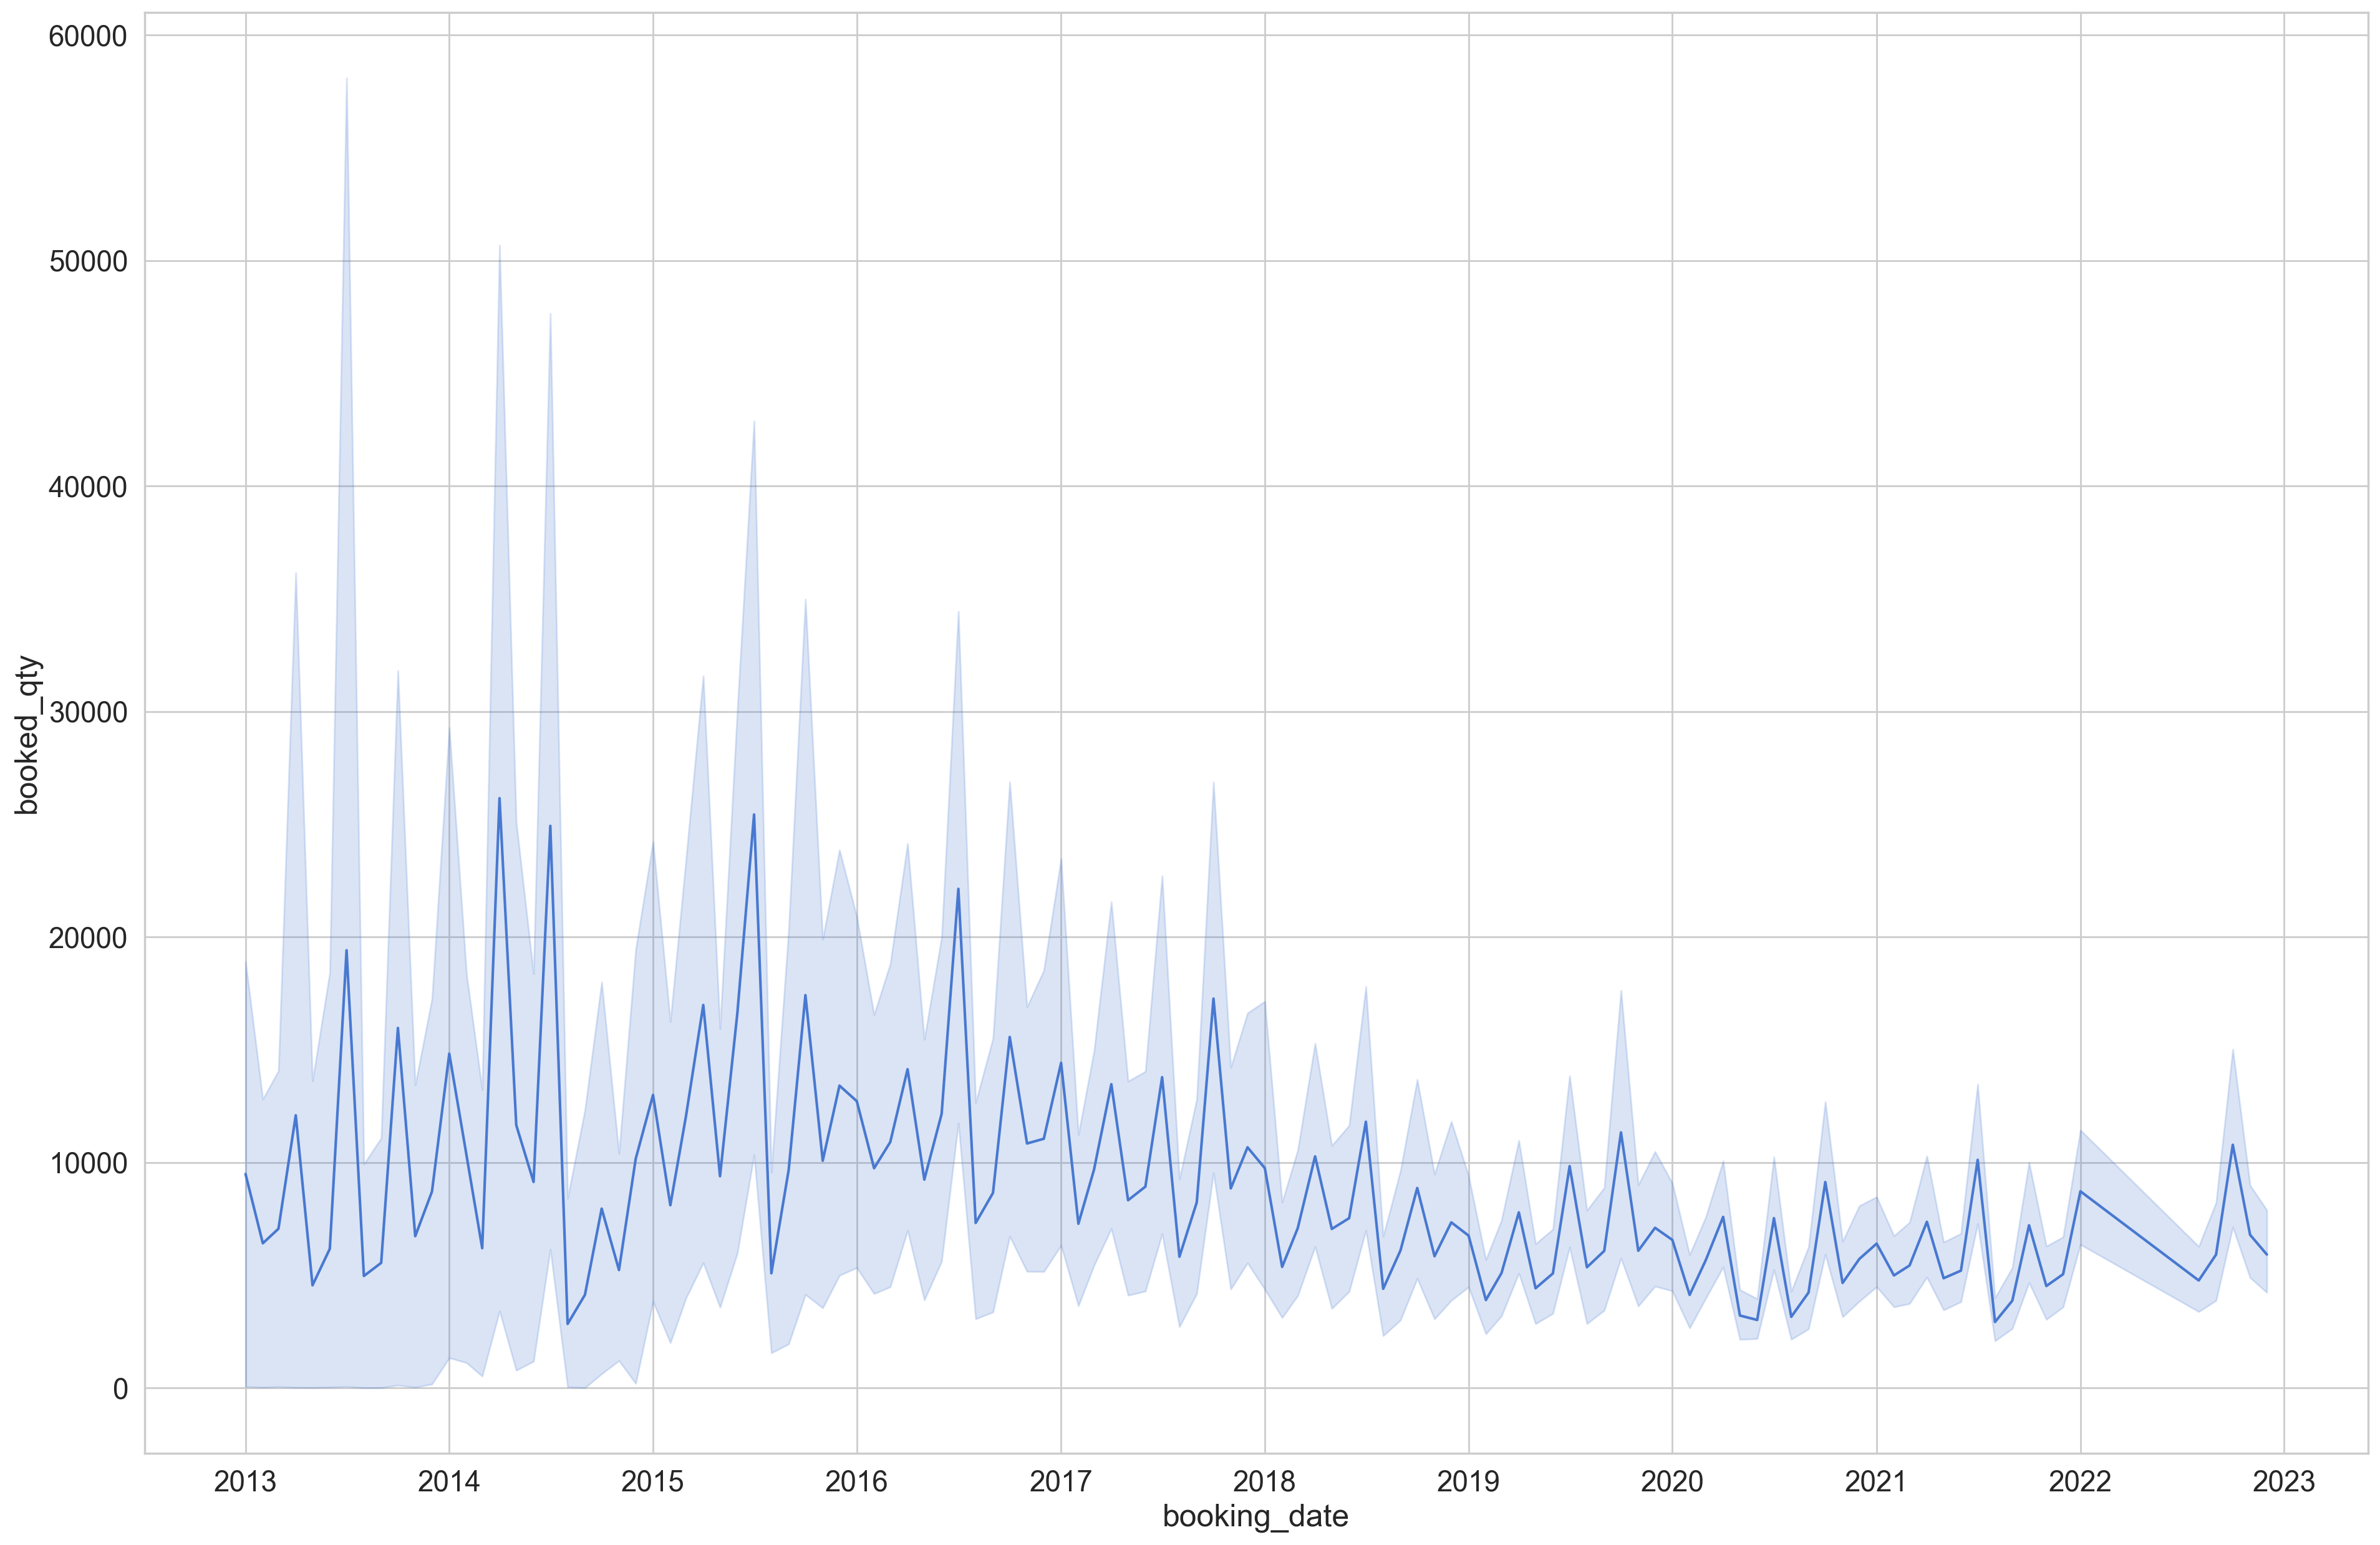

In [9]:
sns.lineplot(x=df["booking_date"], y="booked_qty", data=df)

## <u><i>TRAINING [PROPHET]</i></u>

In [10]:
df.tail()

,month,year,fiscal_date,quarter,booking_date,booked_qty,business_unit,product_family,plid,mean_across_quarter,percentage_mean_change
10991,6,2011,2011-06-01,2,2020-06-01,229,17,72,249,0.0,0.0
10992,5,2011,2011-05-01,2,2020-05-01,289,17,72,249,0.0,0.0
10993,7,2012,2012-07-01,3,2021-07-01,1231,17,72,249,0.0,0.0
10994,6,2012,2012-06-01,2,2021-06-01,591,17,72,249,0.0,0.0
10995,5,2012,2012-05-01,2,2021-05-01,601,17,72,249,0.0,0.0


In [11]:
# imports
# !pip install prophet
from prophet import Prophet

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# uniques
no_products = df["plid"].nunique()
no_fams = df["product_family"].nunique()
no_business_units = df["business_unit"].nunique()
print("unique products:", no_products)
print("unique families:", no_fams)
print("unique business units:", no_business_units)

unique products: 250
unique families: 73
unique business units: 18


In [13]:
# regressing by product family
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_scores = []
rmse_scores = []
num = {}
with open("numerifications.json", 'r') as f:
    num = json.load(f)
 
train_datas, test_datas = train_test_split(df, test_size=0.15, shuffle=True)

for i in range(no_fams):
    print(i)
    train_df = train_datas.loc[train_datas['product_family'] == i][["booking_date", "booked_qty"]]
    train_df.columns = ["ds", "y"]
    train_df = train_df.sort_values(by='ds')

    test_df = test_datas.loc[test_datas['product_family'] == i][["booking_date", "booked_qty"]]
    test_df.columns = ["ds", "y"]
    test_df = test_df.sort_values(by='ds')
    test_df.head()
    train_df = train_df.reset_index()

    train_df.drop("index", inplace = True, axis = 1)
    # print(train_df,'asiduhanisugydasd')
    # print("before mean:", train_df.shape)
    
    after_mean = train_df.groupby("ds")["y"].sum()
    after_mean = after_mean.reset_index()
    after_mean.columns = ["ds", 'y']

    # print("after mean:", after_mean.shape)

    model = Prophet()
    model.fit(after_mean)


    # extrapolating output
    # future = pd.DataFrame(pd.date_range(start='2012-01-01', end='2024-12-31', freq='MS'), columns = ["ds"])
    forecast = model.predict(test_df)
    # print(forecast)
    # print(after_mean['y'],train_df['y'])
    # # print(after_mean)
    # mae = mean_absolute_error(after_mean['y'], train_df['y'])
    # rmse = np.sqrt(mean_squared_error(after_mean['y'], train_df['y']))
    # mae_scores.append(mae)
    # rmse_scores.append(rmse)
    # model.plot(forecast)

    # fam_name = num["Product Family"][str(i)]
    # plt.savefig(f"prophet_results/{str(fam_name)}.png")


0


06:32:53 - cmdstanpy - INFO - Chain [1] start processing
06:32:54 - cmdstanpy - INFO - Chain [1] done processing
06:32:54 - cmdstanpy - INFO - Chain [1] start processing


1


06:32:54 - cmdstanpy - INFO - Chain [1] done processing
06:32:54 - cmdstanpy - INFO - Chain [1] start processing


2


06:32:55 - cmdstanpy - INFO - Chain [1] done processing
06:32:55 - cmdstanpy - INFO - Chain [1] start processing


3


06:32:55 - cmdstanpy - INFO - Chain [1] done processing
06:32:55 - cmdstanpy - INFO - Chain [1] start processing


4


06:32:55 - cmdstanpy - INFO - Chain [1] done processing
06:32:56 - cmdstanpy - INFO - Chain [1] start processing


5


06:32:56 - cmdstanpy - INFO - Chain [1] done processing
06:32:56 - cmdstanpy - INFO - Chain [1] start processing


6


06:33:09 - cmdstanpy - INFO - Chain [1] done processing
06:33:09 - cmdstanpy - INFO - Chain [1] start processing


7


06:33:10 - cmdstanpy - INFO - Chain [1] done processing
06:33:10 - cmdstanpy - INFO - Chain [1] start processing


8


06:33:10 - cmdstanpy - INFO - Chain [1] done processing
06:33:11 - cmdstanpy - INFO - Chain [1] start processing


9


06:33:11 - cmdstanpy - INFO - Chain [1] done processing
06:33:11 - cmdstanpy - INFO - Chain [1] start processing


10


06:33:11 - cmdstanpy - INFO - Chain [1] done processing
06:33:12 - cmdstanpy - INFO - Chain [1] start processing
06:33:12 - cmdstanpy - INFO - Chain [1] done processing


11


06:33:12 - cmdstanpy - INFO - Chain [1] start processing


12


06:33:12 - cmdstanpy - INFO - Chain [1] done processing
06:33:12 - cmdstanpy - INFO - Chain [1] start processing


13


06:33:13 - cmdstanpy - INFO - Chain [1] done processing
06:33:13 - cmdstanpy - INFO - Chain [1] start processing


14


06:33:13 - cmdstanpy - INFO - Chain [1] done processing
06:33:13 - cmdstanpy - INFO - Chain [1] start processing
06:33:13 - cmdstanpy - INFO - Chain [1] done processing


15


06:33:13 - cmdstanpy - INFO - Chain [1] start processing


16


06:33:13 - cmdstanpy - INFO - Chain [1] done processing
06:33:14 - cmdstanpy - INFO - Chain [1] start processing


17


06:33:31 - cmdstanpy - INFO - Chain [1] done processing
06:33:31 - cmdstanpy - INFO - Chain [1] start processing


18


06:33:31 - cmdstanpy - INFO - Chain [1] done processing
06:33:31 - cmdstanpy - INFO - Chain [1] start processing


19


06:33:32 - cmdstanpy - INFO - Chain [1] done processing
06:33:32 - cmdstanpy - INFO - Chain [1] start processing


20


06:33:32 - cmdstanpy - INFO - Chain [1] done processing
06:33:32 - cmdstanpy - INFO - Chain [1] start processing


21


06:33:33 - cmdstanpy - INFO - Chain [1] done processing
06:33:33 - cmdstanpy - INFO - Chain [1] start processing


22


06:33:33 - cmdstanpy - INFO - Chain [1] done processing
06:33:33 - cmdstanpy - INFO - Chain [1] start processing


23


06:33:34 - cmdstanpy - INFO - Chain [1] done processing
06:33:34 - cmdstanpy - INFO - Chain [1] start processing


24


06:33:34 - cmdstanpy - INFO - Chain [1] done processing
06:33:35 - cmdstanpy - INFO - Chain [1] start processing


25


06:33:35 - cmdstanpy - INFO - Chain [1] done processing
06:33:35 - cmdstanpy - INFO - Chain [1] start processing


26


06:33:35 - cmdstanpy - INFO - Chain [1] done processing
06:33:36 - cmdstanpy - INFO - Chain [1] start processing


27


06:33:36 - cmdstanpy - INFO - Chain [1] done processing
06:33:36 - cmdstanpy - INFO - Chain [1] start processing


28


06:33:37 - cmdstanpy - INFO - Chain [1] done processing
06:33:37 - cmdstanpy - INFO - Chain [1] start processing


29


06:33:37 - cmdstanpy - INFO - Chain [1] done processing
06:33:38 - cmdstanpy - INFO - Chain [1] start processing


30


06:33:38 - cmdstanpy - INFO - Chain [1] done processing
06:33:38 - cmdstanpy - INFO - Chain [1] start processing


31


06:33:38 - cmdstanpy - INFO - Chain [1] done processing
06:33:39 - cmdstanpy - INFO - Chain [1] start processing


32


06:33:39 - cmdstanpy - INFO - Chain [1] done processing
06:33:39 - cmdstanpy - INFO - Chain [1] start processing


33


06:33:40 - cmdstanpy - INFO - Chain [1] done processing
06:33:40 - cmdstanpy - INFO - Chain [1] start processing


34


06:33:40 - cmdstanpy - INFO - Chain [1] done processing
06:33:40 - cmdstanpy - INFO - Chain [1] start processing


35


06:33:41 - cmdstanpy - INFO - Chain [1] done processing
06:33:41 - cmdstanpy - INFO - Chain [1] start processing


36


06:33:41 - cmdstanpy - INFO - Chain [1] done processing
06:33:41 - cmdstanpy - INFO - Chain [1] start processing


37


06:33:42 - cmdstanpy - INFO - Chain [1] done processing
06:33:42 - cmdstanpy - INFO - Chain [1] start processing


38


06:33:42 - cmdstanpy - INFO - Chain [1] done processing
06:33:42 - cmdstanpy - INFO - Chain [1] start processing


39


06:33:43 - cmdstanpy - INFO - Chain [1] done processing
06:33:43 - cmdstanpy - INFO - Chain [1] start processing
06:33:43 - cmdstanpy - INFO - Chain [1] done processing


40


06:33:43 - cmdstanpy - INFO - Chain [1] start processing
06:33:43 - cmdstanpy - INFO - Chain [1] done processing


41


06:33:43 - cmdstanpy - INFO - Chain [1] start processing
06:33:43 - cmdstanpy - INFO - Chain [1] done processing


42


06:33:43 - cmdstanpy - INFO - Chain [1] start processing


43


06:33:59 - cmdstanpy - INFO - Chain [1] done processing
06:33:59 - cmdstanpy - INFO - Chain [1] start processing


44


06:34:09 - cmdstanpy - INFO - Chain [1] done processing
06:34:09 - cmdstanpy - INFO - Chain [1] start processing


45


06:34:09 - cmdstanpy - INFO - Chain [1] done processing
06:34:09 - cmdstanpy - INFO - Chain [1] start processing


46


06:34:10 - cmdstanpy - INFO - Chain [1] done processing
06:34:10 - cmdstanpy - INFO - Chain [1] start processing


47


06:34:10 - cmdstanpy - INFO - Chain [1] done processing
06:34:10 - cmdstanpy - INFO - Chain [1] start processing


48


06:34:11 - cmdstanpy - INFO - Chain [1] done processing
06:34:11 - cmdstanpy - INFO - Chain [1] start processing


49


06:34:11 - cmdstanpy - INFO - Chain [1] done processing
06:34:11 - cmdstanpy - INFO - Chain [1] start processing


50


06:34:30 - cmdstanpy - INFO - Chain [1] done processing
06:34:30 - cmdstanpy - INFO - Chain [1] start processing


51


06:34:31 - cmdstanpy - INFO - Chain [1] done processing
06:34:31 - cmdstanpy - INFO - Chain [1] start processing


52


06:34:32 - cmdstanpy - INFO - Chain [1] done processing
06:34:32 - cmdstanpy - INFO - Chain [1] start processing
06:34:32 - cmdstanpy - INFO - Chain [1] done processing


53


06:34:32 - cmdstanpy - INFO - Chain [1] start processing


54


06:34:32 - cmdstanpy - INFO - Chain [1] done processing
06:34:33 - cmdstanpy - INFO - Chain [1] start processing


55


06:34:33 - cmdstanpy - INFO - Chain [1] done processing
06:34:33 - cmdstanpy - INFO - Chain [1] start processing


56


06:34:33 - cmdstanpy - INFO - Chain [1] done processing
06:34:33 - cmdstanpy - INFO - Chain [1] start processing


57


06:34:34 - cmdstanpy - INFO - Chain [1] done processing
06:34:34 - cmdstanpy - INFO - Chain [1] start processing


58


06:34:34 - cmdstanpy - INFO - Chain [1] done processing
06:34:35 - cmdstanpy - INFO - Chain [1] start processing


59


06:34:35 - cmdstanpy - INFO - Chain [1] done processing
06:34:35 - cmdstanpy - INFO - Chain [1] start processing


60


06:34:35 - cmdstanpy - INFO - Chain [1] done processing
06:34:35 - cmdstanpy - INFO - Chain [1] start processing


61


06:34:36 - cmdstanpy - INFO - Chain [1] done processing
06:34:36 - cmdstanpy - INFO - Chain [1] start processing


62


06:34:36 - cmdstanpy - INFO - Chain [1] done processing
06:34:36 - cmdstanpy - INFO - Chain [1] start processing


63


06:34:36 - cmdstanpy - INFO - Chain [1] done processing
06:34:37 - cmdstanpy - INFO - Chain [1] start processing


64


06:34:37 - cmdstanpy - INFO - Chain [1] done processing
06:34:37 - cmdstanpy - INFO - Chain [1] start processing


65


06:34:38 - cmdstanpy - INFO - Chain [1] done processing
06:34:38 - cmdstanpy - INFO - Chain [1] start processing
06:34:38 - cmdstanpy - INFO - Chain [1] done processing


66


06:34:38 - cmdstanpy - INFO - Chain [1] start processing


67


06:34:38 - cmdstanpy - INFO - Chain [1] done processing
06:34:38 - cmdstanpy - INFO - Chain [1] start processing


68


06:34:38 - cmdstanpy - INFO - Chain [1] done processing
06:34:39 - cmdstanpy - INFO - Chain [1] start processing


69


06:34:39 - cmdstanpy - INFO - Chain [1] done processing
06:34:39 - cmdstanpy - INFO - Chain [1] start processing


70


06:34:39 - cmdstanpy - INFO - Chain [1] done processing
06:34:39 - cmdstanpy - INFO - Chain [1] start processing


71


06:34:40 - cmdstanpy - INFO - Chain [1] done processing
06:34:40 - cmdstanpy - INFO - Chain [1] start processing


72


06:34:40 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
mae = mean_absolute_error(test_df['y'], forecast['yhat'])
rmse = np.sqrt(mean_squared_error(test_df['y'], forecast['yhat']))
print(f"For Product Family {i}, MAE: {mae}, RMSE: {rmse}")

For Product Family 72, MAE: 274.71876614091076, RMSE: 364.85333469399654


In [15]:
df.head()

,month,year,fiscal_date,quarter,booking_date,booked_qty,business_unit,product_family,plid,mean_across_quarter,percentage_mean_change
0,8,2022,2022-08-01,3,2016-08-01,204,0,0,0,8.666667,0.000000
1,10,2022,2022-10-01,4,2016-10-01,564,0,0,0,505.000000,0.000000
2,9,2022,2022-09-01,3,2016-09-01,1476,0,0,0,12.333333,0.423077
3,8,2002,2002-08-01,3,2017-08-01,374,0,0,0,73.500000,0.000000
4,10,2002,2002-10-01,4,2017-10-01,6094,0,0,0,193.500000,0.000000


In [23]:
group_pf = df.groupby(['product_family'])

In [17]:
bu_types = df["business_unit"].unique()
pf_types = df["product_family"].unique()
plid_types = df["plid"].unique()
# fq_types = df["quarter"].unique()
# fm_types = df["fiscal month"].unique()

In [25]:
for prod_fam in pf_types:
    vals_for_pfs = group_pf.get_group(prod_fam)
    print(prod_fam, ':', [x for x in vals_for_pfs['plid'].unique()], ',')

0 : [0, 1] ,
1 : [2, 3, 4] ,
2 : [5, 6, 7, 8, 9, 10, 11, 12] ,
3 : [13, 14, 15, 16, 17, 18, 19, 20, 21, 22] ,
4 : [23, 24, 25, 26, 27] ,
5 : [28] ,
6 : [29] ,
7 : [30] ,
8 : [31, 32] ,
9 : [33, 34, 35] ,
10 : [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] ,
11 : [60] ,
12 : [61, 62, 63, 64, 65, 66, 67, 68, 69, 70] ,
13 : [71] ,
14 : [72] ,
15 : [73] ,
16 : [74] ,
17 : [75, 76] ,
18 : [77, 78, 79, 80, 81, 82, 83] ,
19 : [84, 85, 86, 87] ,
20 : [88, 89, 90, 91] ,
21 : [92, 93] ,
22 : [94, 95, 96, 97] ,
23 : [98, 99, 100, 101] ,
24 : [102, 103, 104, 105, 106] ,
25 : [107] ,
26 : [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118] ,
27 : [119, 120, 121, 122, 123] ,
28 : [124, 125] ,
29 : [126] ,
30 : [127] ,
31 : [128, 129, 130, 131] ,
32 : [132, 133, 134] ,
33 : [135] ,
34 : [136] ,
35 : [137, 138, 139] ,
36 : [140, 141, 142, 143, 144, 145] ,
37 : [146, 147, 148] ,
38 : [149] ,
39 : [150, 151, 152] ,
40 : [153, 154] ,
41 : [155, 156, 1

In [26]:
#creating dictionary of type {product_family:[plids in this product_family]}
fam_id_dic = {
    0 : [0, 1] ,
1 : [2, 3, 4] ,
2 : [5, 6, 7, 8, 9, 10, 11, 12] ,
3 : [13, 14, 15, 16, 17, 18, 19, 20, 21, 22] ,
4 : [23, 24, 25, 26, 27] ,
5 : [28] ,
6 : [29] ,
7 : [30] ,
8 : [31, 32] ,
9 : [33, 34, 35] ,
10 : [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59] ,
11 : [60] ,
12 : [61, 62, 63, 64, 65, 66, 67, 68, 69, 70] ,
13 : [71] ,
14 : [72] ,
15 : [73] ,
16 : [74] ,
17 : [75, 76] ,
18 : [77, 78, 79, 80, 81, 82, 83] ,
19 : [84, 85, 86, 87] ,
20 : [88, 89, 90, 91] ,
21 : [92, 93] ,
22 : [94, 95, 96, 97] ,
23 : [98, 99, 100, 101] ,
24 : [102, 103, 104, 105, 106] ,
25 : [107] ,
26 : [108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118] ,
27 : [119, 120, 121, 122, 123] ,
28 : [124, 125] ,
29 : [126] ,
30 : [127] ,
31 : [128, 129, 130, 131] ,
32 : [132, 133, 134] ,
33 : [135] ,
34 : [136] ,
35 : [137, 138, 139] ,
36 : [140, 141, 142, 143, 144, 145] ,
37 : [146, 147, 148] ,
38 : [149] ,
39 : [150, 151, 152] ,
40 : [153, 154] ,
41 : [155, 156, 157, 158] ,
42 : [159, 160] ,
43 : [161, 162, 163] ,
44 : [164, 165, 166] ,
45 : [167, 168, 169, 170, 171, 172] ,
46 : [173] ,
47 : [174] ,
48 : [175] ,
49 : [176] ,
50 : [177, 178] ,
51 : [179] ,
52 : [180, 181, 182, 183, 184, 185, 186] ,
53 : [187, 188] ,
54 : [189, 190] ,
55 : [191] ,
56 : [192, 193] ,
57 : [194] ,
58 : [195] ,
59 : [196, 197, 198, 199, 200] ,
60 : [201, 202, 203, 204, 205, 206, 207] ,
61 : [208, 209, 210, 211, 212, 213, 214, 215, 216] ,
62 : [217, 218, 219, 220, 221] ,
63 : [222, 223, 224, 225, 226, 227, 228, 229] ,
64 : [230, 231] ,
65 : [232, 233] ,
66 : [234, 235, 236, 237, 238, 239] ,
67 : [240] ,
68 : [241, 242] ,
69 : [243, 244] ,
70 : [245, 246] ,
71 : [247, 248] ,
72 : [249]
}

In [27]:
group_pf_id = df.groupby(['product_family', 'plid'])

In [31]:
#dictionary of the type {(prod_fam, plid): number of plids}
dict_of_pf_length = {} #{prod_fam : length of prod_fam}
for prod_fam in pf_types:
    dict_of_pf_length[prod_fam] = len(group_pf.get_group(prod_fam))
dict_of_plid_count = {}
for prod_fam in pf_types:
    for plid in fam_id_dic[prod_fam]:
        dict_of_plid_count[(prod_fam, plid)] = len(group_pf_id.get_group((prod_fam,plid)))/dict_of_pf_length[prod_fam]
print(dict_of_plid_count)

{(0, 0): 0.5231788079470199, (0, 1): 0.4768211920529801, (1, 2): 0.3333333333333333, (1, 3): 0.3188405797101449, (1, 4): 0.34782608695652173, (2, 5): 0.07006369426751592, (2, 6): 0.10828025477707007, (2, 7): 0.15286624203821655, (2, 8): 0.18471337579617833, (2, 9): 0.15286624203821655, (2, 10): 0.12738853503184713, (2, 11): 0.10828025477707007, (2, 12): 0.09554140127388536, (3, 13): 0.064, (3, 14): 0.132, (3, 15): 0.036, (3, 16): 0.048, (3, 17): 0.168, (3, 18): 0.168, (3, 19): 0.152, (3, 20): 0.044, (3, 21): 0.028, (3, 22): 0.16, (4, 23): 0.20689655172413793, (4, 24): 0.06896551724137931, (4, 25): 0.18007662835249041, (4, 26): 0.26053639846743293, (4, 27): 0.2835249042145594, (5, 28): 1.0, (6, 29): 1.0, (7, 30): 1.0, (8, 31): 0.44, (8, 32): 0.56, (9, 33): 0.45901639344262296, (9, 34): 0.45901639344262296, (9, 35): 0.08196721311475409, (10, 36): 0.04275092936802974, (10, 37): 0.016728624535315983, (10, 38): 0.05762081784386617, (10, 39): 0.040892193308550186, (10, 40): 0.063197026022304

In [37]:
import pickle
with open('family_proportions.json', 'wb') as fp:
    pickle.dump(dict_of_plid_count, fp)
